# Classification Assignment

The main goal of this assignment is to check in on your ability to access, load, explore, and make predictions using classification models.  For next Wednesday, you are to do the following:

1. Locate a dataset on Kaggle, NYC Open Data, UCI Machine Learning Repository, or other resource that contains data that can be addressed through a classification task
2. Load and explore the data for missing values and perform a brief EDA
3. Frame and state the classification problem
4. Split your data into train and test sets
4. Implement a `DummyClassifier`, `KNeighborsClassifier`, and `LogisticRegression` model.
5. Improve the models by performing a `GridSearchCV` for `n_neighbors` and `C` parameters respectively.  Include a scale transformation in your pipeline for KNN and a `PolynomialFeatures` step in the Logistic model.
6. Discuss the outcome of your classifiers using the `classification_report`.  Which did the best?  Do you prefer a recall or a precision oriented model?  Why?

**EXTRA**:

- Include `SGDClassifier`
- Incorporate AUC and ROC curves


Note: If you can't find a good dataset, use the titanic dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report

# set chart style
sns.set(style='ticks')
%matplotlib inline

# choose laptop location
home = '/Users/karenhao'
office = '/users/khao'

location = office+'/Google Drive/02 Working/Quartz/Education/GA Data Science/DAT-NYC-6.13'

### step 0. import data

**About the data**

https://www.kaggle.com/kemical/kickstarter-projects


* `ID`: internal kickstarter id
* `name`: name of kickstarter project
* `category`: category
* `main_category`: category of campaign
* `currency`: currency used to support
* `deadline`: deadline for crowdfunding
* `goal`: fundraising goal in local currency
* `launched`: date launched
* `pledged`: amount of money pledged in local currency
* `state`: state of campaign (successful, failed, other)
* `backers`: number of backers
* `country`: country pledged from
* `usd pledged`: amount of money pledged in usd
* `usd_pledged_real`: amount of money pledged in usd
* `usd_goal_real`: fundraising goal in usd

In [2]:
os.chdir(location+'/data')
kickstarter = pd.read_csv('ks-projects-201801.csv')

In [3]:
kickstarter.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### step 1. check for null values

In [4]:
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


It looks like `name` and `usd pledged` are the only columns with null values. We don't care about `name`, but we might care about `usd pledged`.

In [5]:
kickstarter[kickstarter['usd pledged'].isnull()].head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
824,1004013077,Spencer Capier Instrumental Project 2015,Music,Music,CAD,2014-10-10,4000.0,2014-09-10 22:51:01,4760.00,undefined,0,"N,0""",NaN,4251.14,3572.39
844,1004126342,LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...,Music,Music,USD,2015-06-11,5000.0,2015-05-15 02:12:35,6370.00,undefined,0,"N,0""",NaN,6370.00,5000.00
864,1004255433,The Battle For Breukelen: A Neighborhood Epic,Film & Video,Film & Video,USD,2015-11-07,6000.0,2015-10-10 18:45:24,6695.00,undefined,0,"N,0""",NaN,6695.00,6000.00
870,1004298993,"""Tamboura Plays Violin"" - a collection of Pop ...",Music,Music,USD,2015-03-28,2750.0,2015-02-11 19:28:27,2926.00,undefined,0,"N,0""",NaN,2926.00,2750.00
890,1004402863,Nightingale Noel - An A Cappella Holiday CD,Music,Music,USD,2015-12-11,1200.0,2015-11-11 21:02:55,1585.00,undefined,0,"N,0""",NaN,1585.00,1200.00


From examinining rows where `usd pledged` is null, it seems ok to use `usd_pledged_real` instead, which accurately converts `pledged` to usd.

### step 2. understanding existing variables

Now we continue to explore each of the columns.

In [6]:
kickstarter.category.value_counts().head(10)

Product Design    22314
Documentary       16139
Music             15727
Tabletop Games    14180
Shorts            12357
Video Games       11830
Food              11493
Film & Video      10108
Fiction            9169
Fashion            8554
Name: category, dtype: int64

In [7]:
kickstarter.main_category.value_counts()

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

In [8]:
kickstarter.currency.value_counts()

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

In [9]:
kickstarter.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

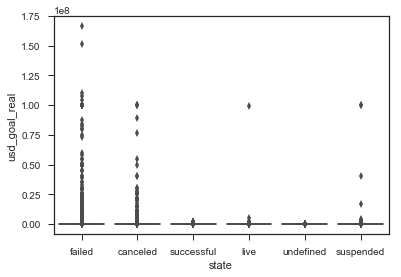

In [10]:
sns.boxplot(x='state',y='usd_goal_real',data=kickstarter)

Because of the outliers in `usd_goal_real`, it's too hard to tell what is actually going on in the above boxplot. Let's get rid of outliers.

In [11]:
# check distribution
kickstarter.usd_goal_real.describe()

count    3.786610e+05
mean     4.545440e+04
std      1.152950e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.550000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

In [12]:
# remove outliers
ks = kickstarter.copy()
ks = ks[ks.usd_goal_real<ks.usd_goal_real.quantile(.95)]

ks.usd_goal_real.describe()

count    359488.000000
mean      10952.144222
std       14405.316904
min           0.010000
25%        2000.000000
50%        5000.000000
75%       14000.000000
max       79987.000000
Name: usd_goal_real, dtype: float64

Now we can try visualizing `usd_goal_real` again.

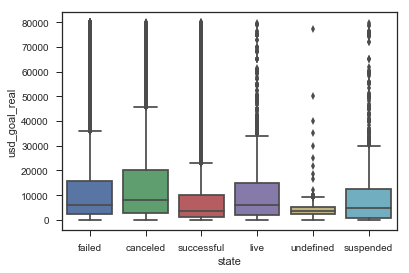

In [13]:
sns.boxplot(x='state',y='usd_goal_real',data=ks)

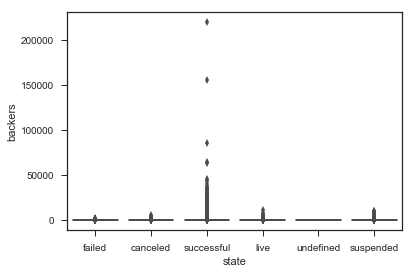

In [14]:
sns.boxplot(x='state',y='backers',data=ks)

Once again, there are too many outliers in `backers`. Let's do the same thing as we did with `usd_goal_real`.

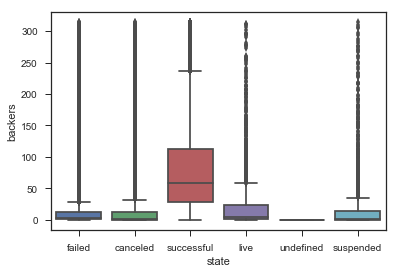

In [15]:
# remove outliers again
ks = ks[ks.backers<ks.backers.quantile(.95)]
sns.boxplot(x='state',y='backers',data=ks)

Based on the above boxplot, `backers` seems like a great way to classify the success of a campaign.

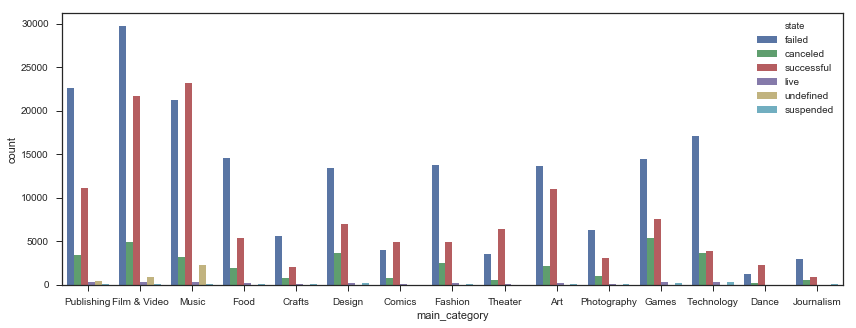

In [16]:
fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(x='main_category',hue='state',data=ks,ax=ax)

The `main_category`, on the other hand, doesn't seem like a great way to classify success.

### step 3. create new variables

Let's calculate a new variable from `launched` and `deadline` that represents the duration of the campaign.

In [17]:
# convert columns to dates
ks['launched'] = pd.to_datetime(ks.launched).dt.date
ks['deadline'] = pd.to_datetime(ks.deadline).dt.date

# calculate new variable
ks['duration'] = (ks.deadline - ks.launched).dt.days

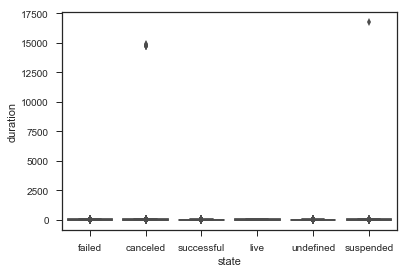

In [18]:
sns.boxplot(x='state',y='duration',data=ks)

Remove outliers again.

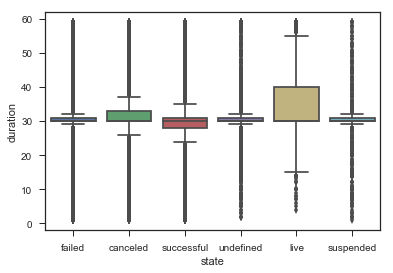

In [19]:
ks = ks[ks.duration<ks.duration.quantile(.95)]
sns.boxplot(x='state',y='duration',data=ks)

Let's simplify `state` to have only binary values that indicate successful and unsuccessful campaigns.

In [20]:
ks['state_simple'] = ks.state.apply(lambda state: 1 if state=='successful' else 0)

In [22]:
ks.state_simple.value_counts()

0    199048
1    107981
Name: state_simple, dtype: int64

Let's also create dummy variables for `category`, `main_category`, and `currency`.

In [26]:
category = pd.get_dummies(ks.category, drop_first=True)
main_category = pd.get_dummies(ks.main_category, drop_first=True)
currency = pd.get_dummies(ks.currency, drop_first=True)

# put all categorical variables in one df
cat_var = pd.concat([category,main_category,currency],axis=1)

In [27]:
cat_var.head()

,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,Architecture,Art,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### step 4. implement classification model

We are now ready to implement different classification models. Let's first use a KNeighbors model and try feeding the model everything.

In [28]:
X = ks[['duration','backers','usd_goal_real']].join(cat_var)
y = ks.state_simple

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [30]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

accuracy_score(y_test,y_pred)

0.91159227702649892

Let's try it again with only `duration`, `backers`, and `usd_goal_real`.

In [31]:
X = ks[['duration','backers','usd_goal_real']]
y = ks.state_simple

X_train,X_test,y_train,y_test = train_test_split(X,y)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

accuracy_score(y_test,y_pred)

0.90911696500690486

Let's try one last time with `backers` only.

In [32]:
X = ks[['backers']]
y = ks.state_simple

X_train,X_test,y_train,y_test = train_test_split(X,y)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

accuracy_score(y_test,y_pred)

0.80025534797675812

Clearly the model with everything works best.